### Import statements

In [1]:
from dicesapi import DicesAPI, SpeechGroup
from dicesapi.jupyter import NotebookPBar
from dicesapi.text import CtsAPI
import pandas as pd
from matplotlib import pyplot as plt
import os
import re
import json
import numpy as np
from sklearn.decomposition import PCA
import dicesapi.text

### Connection to DICES

In [2]:
api = DicesAPI(
    dices_api = 'http://localhost:8000/api', 
    logfile = 'nonnus.log', 
    progress_class = NotebookPBar,
)
cts = CtsAPI(
    dices_api = api,
    servers = {None:'http://localhost:5000/cts'},
)

### Read the list of mother-child pairs

In [3]:
mothers_file = os.path.join('data', 'mother-child.csv')
mothers = pd.read_csv(mothers_file, sep='\t')
mothers

,spkr,addr
0,Alcimede,Jason
1,Aphrodite,Eros
2,Chalciope,Argus (son of Phrixus)
3,Chalciope,sons of Phrixus
4,Chariclo,Tiresias
...,...,...
56,Venus-huntress,Aeneas
57,Venus,Amor
58,Venus,Aeneas
59,Cybele,Jupiter


### Download mother speeches

In [4]:
# get speeches
mother_speeches = [
    api.getSpeeches(spkr_inst_name=rec['spkr'], addr_inst_name=rec['addr']) 
    for rec in mothers.to_dict(orient='records')]

# add them to the table
mothers = mothers.assign(
    speeches = mother_speeches,
    n = [len(speech_group) for speech_group in mother_speeches]
)
    
# turn the downloaded speeches into a SpeechGroup
empty = SpeechGroup([], api=api)
mother_speeches = sum(mothers.speeches, start=empty)

In [5]:
print([s.id for s in mother_speeches])

[129, 4401, 2305, 1549, 1373, 4553, 1995, 2511, 4548, 658, 2476, 3166, 4679, 4094, 2090, 4396, 483, 23, 564, 161, 505, 1458, 4144, 1540, 4078, 4416, 3284, 485, 4483, 4176, 25, 950, 4251, 3286, 4382, 3285, 131, 1895, 507, 3584, 582, 1538, 3508, 2072, 1455, 696, 2785, 1456, 1536, 1324, 1732, 4218, 4673, 946, 1571, 3215, 1737, 4334, 4549, 2050, 1102, 1169, 4670, 948, 3134, 3496, 3167, 487, 1106, 4630, 4628, 2871, 4327, 2723, 561, 3234, 4311, 2922, 3490, 4332, 4355, 3067, 2803, 2977, 1387, 4269, 3641, 3104, 604, 4282, 3696]


### Download the entire corpus to use as a benchmark

Note that because of the way DicesAPI caches speech objects, the ones we've already downloaded are reused here and not duplicated or re-downloaded. If the API sees that we've requested the same speech, we just get a pointer to the earlier one.

In [5]:
all_speeches = api.getSpeeches(progress=True)

#### ⚠️ Workaround for certain Perseus texts

These texts have an extra hierarchical level inserted into their loci on Perseus' CTS server. This is a temporary workaround to convert our loci to a form that the server understands.

Because `all_speeches` and `mother_speeches` just contain pointers to the same object pool, we can do this modification once on `all_speeches` and the mother speeches will also be affected.

In [6]:
adj_book_line = [
    'De Raptu Proserpinae',
    'In Rufinum',
]
adj_line = [
    'Panegyricus de consulatu Manlii Theodori',
    'Panegyricus de Tertio Consulatu Honorii Augusti',
    'Panegyricus de Sexto Consulatu Honorii Augusti',
    'Epithalamium de Nuptiis Honorii Augusti',
    'De Bello Gothico',
    'Psychomachia',    
]

for s in all_speeches:
    if s.work.title in adj_book_line:
        m = re.fullmatch(r'(\d+)\.(\d+)', s.l_fi)
        if m:
            s.l_fi = f'{m.group(1)}.1.{m.group(2)}'

        m = re.fullmatch(r'(\d+)\.(\d+)', s.l_la)
        if m:
            s.l_la = f'{m.group(1)}.1.{m.group(2)}'

    elif s.work.title in adj_line:
        m = re.fullmatch(r'(\d+)', s.l_fi)
        if m:
            s.l_fi = '1.' + m.group(1)

        m = re.fullmatch(r'(\d+)', s.l_la)
        if m:
            s.l_la = '1.' + m.group(1)

### Get the text

In [7]:
pbar = NotebookPBar(max=len(all_speeches))

for i, s in enumerate(all_speeches):
    if (i % 100 == 0) or (i == len(all_speeches) - 1):
        pbar.update(i)
    if not hasattr(s, 'passage') or s.passage is None:
        s.passage = cts.getPassage(s)
    if s.passage is None:
        print(f'Failed: {s.work.urn}\t{s.work.title}\t{s.l_range}')

Failed: 	Orphic Argonautica	77-96
Failed: 	Orphic Argonautica	98-113
Failed: 	Orphic Argonautica	256-267
Failed: 	Orphic Argonautica	283-294
Failed: 	Orphic Argonautica	335-354
Failed: 	Orphic Argonautica	544-557
Failed: 	Orphic Argonautica	823-828
Failed: 	Orphic Argonautica	832-842
Failed: 	Orphic Argonautica	847-856
Failed: 	Orphic Argonautica	1153-1159
Failed: 	Orphic Argonautica	1164-1174
Failed: 	Orphic Argonautica	1231-1243
Failed: 	Orphic Argonautica	1329-1336
Failed: urn:cts:greekLit:tlg0001.tlg001.perseus-grc2	Argonautica	3.727-3.739
Failed: urn:cts:latinLit:stoa0089.stoa005.perseus-lat2	De Raptu Proserpinae	2.praef.33-2.praef.48
Failed: 	Homerocentones	42-66
Failed: 	Homerocentones	100-176
Failed: 	Homerocentones	178-203
Failed: 	Homerocentones	230-245
Failed: 	Homerocentones	253-263
Failed: 	Homerocentones	265-272
Failed: 	Homerocentones	385-432
Failed: 	Homerocentones	438-441
Failed: 	Homerocentones	444-446
Failed: 	Homerocentones	474-518
Failed: 	Homerocentones	598-605
Fa

Failed: urn:cts:latinLit:phi0959.phi006.perseus-lat2	Metamorphoses	1.545-1.546
Failed: urn:cts:latinLit:phi0959.phi006.perseus-lat2	Metamorphoses	4.793-4.803
Failed: urn:cts:latinLit:phi0959.phi006.perseus-lat2	Metamorphoses	14.383-14.385
Failed: 	D. Sanctae Sophiae	91-98
Failed: 	D. Sanctae Sophiae	220-242
Failed: 	D. Sanctae Sophiae	248-254
Failed: 	Batrachomyomachia	13-21
Failed: 	Batrachomyomachia	25-55
Failed: 	Batrachomyomachia	57-64
Failed: 	Batrachomyomachia	93-97
Failed: 	Batrachomyomachia	110-120
Failed: 	Batrachomyomachia	139-143
Failed: 	Batrachomyomachia	147-159
Failed: 	Batrachomyomachia	174-176
Failed: 	Batrachomyomachia	178-196
Failed: 	Batrachomyomachia	272-276
Failed: 	Batrachomyomachia	278-283
Failed: 	Megara	1-55
Failed: 	Megara	62-125
Failed: urn:cts:latinLit:phi1020.phi001.perseus-lat2	Thebaid	4.832-4.850
Failed: 	Sack of Troy	120-151
Failed: 	Sack of Troy	265-282
Failed: 	Sack of Troy	284-290
Failed: 	Sack of Troy	292-303
Failed: 	Sack of Troy	376-416
Failed: 	Sa

### Add supplementary text for speeches not in Perseus

In [8]:
with open('data/supp_mother_speeches.txt') as f:
    supplement = json.load(f)
    
for rec in supplement:
    for s in all_speeches:
        if s.id == rec['id']:
            print(s)
            s.passage = dicesapi.text.Passage()
            s.passage.line_array = rec['line_array']
            s.passage.text = ' '.join([l['text'] for l in s.passage.line_array])
            s.passage.speech = s
            break

<Speech 4483: Homerocentones 598-605>
<Speech 4548: Homerocentones 2059-2064>
<Speech 4549: Homerocentones 2068-2076>
<Speech 4553: Homerocentones 2187-2188>
<Speech 4416: St. Cyprian 1.1.51-1.1.52>
<Speech 3696: Paraphrase 2.19-2.20>


### Remove some problem speeches

#### No text

In [9]:
test_speeches = all_speeches.advancedFilter(lambda s: s.passage is not None).sorted()

#### Very long speeches

In [10]:
for s in test_speeches:
    if len(s.passage.line_array) > 600:
        print(s)
test_speeches = test_speeches.advancedFilter(lambda s: len(s.passage.line_array)<600).sorted()

<Speech 890: Odyssey 9.2-11.332>
<Speech 957: Odyssey 11.378-12.453>
<Speech 1552: Aeneid 2.3-3.715>


### Class as mother/non-mother

In [11]:
for s in all_speeches:
    if s in mother_speeches:
        s.is_mother = True
    else:
        s.is_mother = False

In [12]:
kept_mother = len([s for s in test_speeches if s.is_mother])
kept_non_mother = len([s for s in test_speeches if not s.is_mother])


print(f'{kept_mother}/{len(mother_speeches)} mother speeches selected')
print(f'{kept_non_mother}/{len(all_speeches) - len(mother_speeches)} non-mother speeches selected')

91/91 mother speeches selected
4018/4601 non-mother speeches selected


### Run NLP

In [13]:
pbar = NotebookPBar(max=len(test_speeches))

for i, s in enumerate(test_speeches):
    if i % 10 == 0 or i == len(test_speeches) - 1:
        pbar.update(i+1)
    if s.passage is not None:
        if s.passage.spacy_doc is None:
            s.passage.runSpacyPipeline(index=False)
    if s.passage.spacy_doc is None:
        print(f'SpaCy Failed: {s.work.urn}\t{s.work.title}\t{s.l_range}')

## Basic stats

In [58]:
pbar = NotebookPBar(max=len(test_speeches))
rows = []

for i, s in enumerate(test_speeches):
    if i % 10 == 0 or i == len(test_speeches) - 1:
        pbar.update(i+1)
    for w in s.passage.spacy_doc:
        morph = w.morph.to_dict()
        
        row = dict(
            speech_id = s.id,
            lang = s.work.lang,    
            auth = s.author.name,
            work = s.work.title,
            loci = s.l_range,
            spkr = ','.join([inst.name for inst in s.spkr]),
            addr = ','.join([inst.name for inst in s.addr]),
            tags = ','.join([tag['type'] for tag in s._attributes.get('tags', [])]),
            part = s.part,
            type = s.type,
            mother = s.is_mother,
            token = w.text,
            nlines = len(s.passage.line_array),
            lemma = w.lemma_,
            upos = w.pos_,
            tag = w.tag_,
            mood = morph.get('Mood'),
            voice = morph.get('Voice'),
            tense = morph.get('Tense'),
            person = morph.get('Person'),
            number = morph.get('Number'),
            case = morph.get('Case'),
            gender = morph.get('Gender'),
            verb = morph.get('VerbForm'),
            pron = morph.get('PronType'),
            poss = morph.get('Poss'),
            )        
        rows.append(row)

token_table = pd.DataFrame(rows)

# drop tokens with no alpha chars
token_table = token_table.loc[token_table.token.str.lower().str.contains(r'[a-zα-ω]')]
token_table

,speech_id,lang,auth,work,loci,spkr,addr,tags,part,type,...,mood,voice,tense,person,number,case,gender,verb,pron,poss
0,1385,greek,Apollonius,Argonautica,1.242-1.246,citizens,citizens,del,1,S,...,None,None,None,None,None,None,None,None,None,None
1,1385,greek,Apollonius,Argonautica,1.242-1.246,citizens,citizens,del,1,S,...,None,None,None,None,None,None,None,None,None,None
2,1385,greek,Apollonius,Argonautica,1.242-1.246,citizens,citizens,del,1,S,...,None,None,None,None,Sing,Nom,Masc,None,Int,None
3,1385,greek,Apollonius,Argonautica,1.242-1.246,citizens,citizens,del,1,S,...,None,None,None,None,Sing,Dat,Masc,None,None,None
4,1385,greek,Apollonius,Argonautica,1.242-1.246,citizens,citizens,del,1,S,...,None,None,None,None,Sing,Nom,Masc,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384374,1868,latin,Virgil,Aeneid,12.947-12.949,Aeneas,Turnus,"thr,tau",2,D,...,None,None,None,None,Sing,Acc,Fem,None,None,None
384375,1868,latin,Virgil,Aeneid,12.947-12.949,Aeneas,Turnus,"thr,tau",2,D,...,None,Pass,Past,None,Sing,Abl,Masc,None,None,None
384376,1868,latin,Virgil,Aeneid,12.947-12.949,Aeneas,Turnus,"thr,tau",2,D,...,None,None,None,None,None,None,None,None,None,None
384377,1868,latin,Virgil,Aeneid,12.947-12.949,Aeneas,Turnus,"thr,tau",2,D,...,None,None,None,None,Sing,Abl,Masc,None,None,None


In [62]:
token_table.loc[token_table.poss=='Yes', ['token', 'lemma', 'upos']]

,token,lemma,upos
126,ταρχύσαο,ταρχύω,ADJ
129,ἐμόν,ἐμός,ADJ
189,ἐμῆς,ἐμός,ADJ
584,ἐμὸν,ἐμός,ADJ
635,ἐμὸν,ἐμός,ADJ
...,...,...,...
283003,ἡμετέρῳ,ἡμέτερος,ADJ
283194,ἐμὸν,ἐμός,ADJ
283252,σῷ,σός,ADJ
340300,ἐμὰ,ἐμός,ADJ


In [74]:
labels = token_table.groupby('speech_id').agg(
    lang = ('lang', 'first'),
    auth = ('auth', 'first'),
    work = ('work', 'first'),
    loci = ('loci', 'first'),
    spkr = ('spkr', 'first'),
    addr = ('addr', 'first'),
    part = ('part', 'first'),
    nlines = ('nlines', 'first'),
    mother = ('mother', 'first'),
    ntokens = ('token', 'count'),
)

In [16]:
labels.groupby(['lang', 'mother', 'auth']).agg(
    speeches = ('loci', 'count'),
    lines = ('nlines', 'sum'),
)

speeches  lines
lang  mother auth                             
greek False  Apollonius             138   1662
             Callimachus             30    214
             Colluthus               14    130
             Hesiod                  12     44
             Homer                 1345  14024
             Homeric Hymns           58    763
             Moschus                  4     39
             Nonnus                 347   7756
             Oppian                  15     70
             Quintus                170   1990
             Theocritus              16    226
      True   Apollonius               4     41
             Callimachus              3     32
             Colluthus                2     30
             Eudocia                  5     28
             Hesiod                   1      3
             Homer                   23    206
             Homeric Hymns            4     32
             Nonnus                   6    143
             Oppian                   1      2
             Quintus                  5     89
             Theocritus               1      3
latin False  Claudian               106   2606
             Lucan                  122   2573
             Ovid                   498   7668
             Prudentius              13    330
             Silius                 312   3832
             Statius                293   3941
             Valerius Flaccus       192   1954
             Virgil                 333   3707
      True   Claudian                 5     51
             Lucan                    1     54
             Ovid                     6     75
             Silius                   6     68
             Statius                 10    202
             Valerius Flaccus         1     15
             Virgil                   7    120

In [18]:
token_table.groupby(['mother', 'lang']).agg(
    speeches = ('speech_id', 'nunique'),
    tokens = ('token', 'count'),
)

speeches  tokens
mother lang                   
False  greek      2149  182451
       latin      1869  182841
True   greek        55    4173
       latin        36    4073

In [19]:
pd.DataFrame(dict(
    lang = s.lang,
    mother = s.is_mother,
    lines = len(s.passage.line_array),
) for s in test_speeches).groupby(['mother', 'lang']).agg(
    speeches = ('lines', 'count'),
    lines = ('lines', 'sum'))

speeches  lines
mother lang                  
False  greek      2149  26918
       latin      1869  26611
True   greek        55    609
       latin        36    585

In [29]:
mask = token_table.mood.isna()
groups = token_table[~mask].groupby(['lang'])

for name, group in groups:
    display(pd.crosstab(group.mother, group.mood, normalize='index')*100)

mood,Imp,Ind,Opt,Sub
mother,,,,
False,10.621743,77.507962,2.887956,8.982339
True,11.451613,78.387097,0.806452,9.354839


mood,Imp,Ind,Sub
mother,,,
False,8.644253,71.514211,19.841536
True,9.163347,71.513944,19.322709


In [32]:
groups = token_table.groupby(['lang'])

for name, group in groups:
    display(pd.crosstab(group.mother, group.person, normalize='index') * 100)

person,1,2,3
mother,,,
False,25.000660,23.581397,51.417944
True,25.221239,25.663717,49.115044


person,1,2,3
mother,,,
False,16.818982,18.600654,64.580364
True,23.306773,21.115538,55.577689


In [45]:
mask = (token_table.upos == 'PRON')
groups = token_table[mask].groupby(['lang'])

for name, group in groups:
    display(name, pd.crosstab(group.mother, group.person))

('greek',)

person,1,2,3
mother,,,
False,3698,3506,2112
True,104,100,43


('latin',)

person
mother


#### Possessives

What tokens are being counted by CLTK?

In [70]:
(token_table.loc[(token_table.upos == 'ADJ') & (token_table.person == 1)]
 .groupby('token')
 .agg(count=('token', 'count'))
 .sort_values('count', ascending=False)
).iloc[:50]

,count
token,


In [69]:
token_table.tag.unique()

array(['Ne', 'V-', 'Pi', 'Nb', 'Df', 'A-', 'Pp', 'G-', 'C-', 'R-', 'Px',
       'Ps', 'S-', 'Ma', 'Dq', 'Pd', 'Mo', 'Pr', 'Du', 'I-', 'Pk', 'F-',
       'Pc', 'noun', 'pronoun', 'verb', 'adverb', 'conjunction',
       'adjective', 'preposition', 'conjuntion', 'proper_noun', 'number',
       'particle', 'interjection', 'INTJ', '_', 'adjective_particle',
       'noun_particle', 'ADP', 'verb_particle', 'NOUN', 'DET',
       'adverb_adverb', 'adverb_particle', 'conjunction_particle'],
      dtype=object)

In [68]:
(token_table.loc[token_table.tag == 'poss']
 .groupby('token')
 .agg(count=('token', 'count'))
 .sort_values('count', ascending=False)
).iloc[:50]

,count
token,


In [72]:
groups = token_table.groupby(['lang'])

for name, group in groups:
    display(name, pd.DataFrame(group.loc[group.upos=='ADJ', 'lemma'].value_counts()[:25]))

('greek',)

,count
lemma,
ἐμός,704
ἄλλος,703
πολύς,696
τίς,595
μέγας,558
Ἀχαιός,456
πᾶς,446
κακός,410
οὗτος,396


('latin',)

,count
lemma,
noster,767
meus,759
tuus,719
omnis,589
magnus,569
suus,393
nullus,322
tantus,273
primus,271


### Personal Pronouns

Again, let's see what gets included.

In [47]:
(token_table.loc[token_table.tag == 'Pp']
 .groupby('token')
 .agg(count=('token', 'count'))
 .sort_values('count', ascending=False)
)[:30]

,count
token,
μοι,1050
τοι,908
σε,647
με,607
ἐγὼ,586
σὺ,510
μιν,411
οἱ,348
μʼ,317


Remove the most frequent misclassifications

In [ ]:
to_remove = ['αὐτὰρ', 'θʼ', 'κʼ', 'ὅττι', 'ἦμαρ', 'μάλʼ', 'αὖτε', 'ἐσσι', 'νυ', 'πώ', 'ἐνθάδʼ', 'ῥα', 'οὕνεκʼ', 'ἦε', 'ἔτʼ', 'ἠμὲν', 'κῆρ', 'δεῦρʼ', 'νύ', 'ὧδʼ', 'χʼ', 'ὀΐω', 'ἦτορ', 'αὐτίκʼ', 'vivo', 'εἵνεκʼ', 'ἄρʼ', 'ποθʼ', 'misero', 'αἲ', 'δῶ', 'μὰ', 'ποθι', 'πάντεσσι', 'κεῖσʼ', 'virum', 'ἄρ', 'ᾗσι', 'ἠδὲ', 'utinam', 'παρὲξ', 'ὧς', 'τοῖα', 'feram', 'tantis', 'totis', 'οὐκί', 'ἄντην', 'uestris', 'Ζεῦ', 'θην', 'μέγʼ', 'οὕνεκα', 'αὐτάρ', 'Ἐνυώ', 'ἀμφοτέρω', 'ἀτάρ', 'novis', 'πέρ', 'ὀίω', 'κεῖθι', 'θεά', 'εὑ', 'αἰνὰ', 'querellis', 'deosque', 'οἴω', 'dis', 'superisque', 'ἐσσὶ', 'ἂψ', 'τῆλε', 'satam', 'ultro', 'verso', 'verum', 'Pisa', 'ὄφρʼ', 'magne', 'tutos', 'aequis', 'illic', 'agedum', 'Achaide', 'ἄναξ', 'ambobus', 'opibusque', 'saeve', 'votisque', 'πρόες',]
mask = cltk_token_table.token.isin(to_remove) & (cltk_token_table.pron == 'personal')
cltk_token_table.loc[mask, 'pron'] = ''

In [ ]:
groups = cltk_token_table.groupby(['lang'])

for name, group in groups:
    display(name, pd.crosstab(group.mother, group.pron, normalize='index'))

## Load hand-selected feature sets

In [ ]:
excel_file = '/Users/chris/Dropbox/Epic Speeches/Listen to mummy/classification.xlsx'
lemma_class = pd.read_excel(excel_file, 'maternal diction')

In [ ]:
lem_dict = dict()

for label in lemma_class.label.unique():
    if not pd.isna(label):
        lem_dict[label] = lemma_class.loc[lemma_class.label == label, 'lemma'].values

In [ ]:
lem_dict['giving']

In [ ]:
cltk_token_table['theme'] = ''

for label in ['family', 'giving', 'memory']:
    mask = cltk_token_table.lemma.isin(lem_dict[label])
    cltk_token_table.loc[mask, 'theme'] = label

In [ ]:
groups = cltk_token_table.groupby(['lang'])

for name, group in groups:
    display(name, pd.crosstab(group.mother, group.theme, normalize='index'))

## Full feature set

In [ ]:
feature_table = (
    cltk_token_table.pivot_table(
        index = 'speech_id',
        columns = 'theme',
        values = 'token',
        aggfunc = 'count',
        fill_value = 0,
    )
    .drop('', axis=1)
.join(
    cltk_token_table.pivot_table(
        index = 'speech_id',
        columns = 'mood',
        values = 'token',
        aggfunc = 'count',
        fill_value = 0,
    )
    .assign(
        subopt = lambda x: x['subjunctive'] + x['optative'])
    
    .drop(['', 'subjunctive', 'optative', 'gerund', 'gerundive'], axis=1)
)
.join(
    cltk_token_table.pivot_table(
        index = 'speech_id',
        columns = 'pers',
        values = 'token',
        aggfunc = 'count',
        fill_value = 0,
    )
    .drop(['', 'first', 'plural', 'second', 'singular'], axis=1)
)
.join(
    cltk_token_table.pivot_table(
        index = 'speech_id',
        columns = 'pron',
        values = 'token',
        aggfunc = 'count',
        fill_value = 0,
    ).loc[:,['interrogative', 'personal', 'reciprocal', 'relative']]
)
.join( 
    cltk_token_table.groupby('speech_id')['poss']
    .value_counts()
    .unstack()
    .fillna(0)
    .rename(columns={'pos':'possessive'})['possessive']
)
.div(labels.ntokens, axis=0)
)

feature_table

### Log frequencies

In [ ]:
x = feature_table.apply(np.log)
x[feature_table==0] = np.nan
x

### Principal Components

In [ ]:
pca_model = PCA(n_components=3)

pca = pd.DataFrame(
    index = feature_table.index,
    data = pca_model.fit_transform(feature_table), 
    columns=['PC1', 'PC2', 'PC3'])

## Plots

In [ ]:
feat = 'family'
label = 'mother'

groups = x.groupby(labels[label])

fig, ax = plt.subplots()
ax.boxplot(
    [group[feat].dropna() for name, group in groups])
ax.set_xticks([j + 1 for j in range(len(groups))],
    labels = [name for name, group in groups])
ax.set_xlabel(label)
ax.set_ylabel('log frequency')
ax.set_title(f'{feat} vocabulary')
plt.savefig(f'{feat}_box.png')
plt.show()

In [ ]:
feat = 'family'
label = 'mother'

groups = x.groupby(labels[label])

fig, ax = plt.subplots()
ax.violinplot(
    [group[feat].dropna() for name, group in groups], showmeans=True)
ax.set_xticks([j + 1 for j in range(len(groups))],
    labels = [name for name, group in groups])
ax.set_xlabel(label)
ax.set_ylabel('log frequency')
ax.set_title(f'{feat} vocabulary')
plt.savefig(f'{feat}_box.png')
plt.show()

In [ ]:
x_feat = 'family'
y_feat = 'giving'
label = 'mother'

fig, ax = plt.subplots()
for label_value in labels[label].unique():
    mask = labels[label]==label_value
    ax.loglog(feature_table.loc[mask, x_feat], feature_table.loc[mask, y_feat], marker='o', linestyle='', label=label_value)
ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.legend(title=label)
plt.show()

In [ ]:
x_feat = 'personal'
y_feat = 'possessive'
label = 'lang'

fig, ax = plt.subplots()
for label_value in labels[label].unique():
    mask = labels[label]==label_value
    ax.loglog(feature_table.loc[mask, x_feat], feature_table.loc[mask, y_feat], marker='o', linestyle='', label=label_value)
ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.legend(title=label)
ax.set_title('pronouns in mother-child speeches')
plt.savefig('pron.png')
plt.show()

In [ ]:
x_feat = 'PC1'
y_feat = 'PC2'
label = 'lang'

fig, ax = plt.subplots()
for label_value in labels[label].unique():
    mask = labels[label]==label_value
    ax.plot(pca.loc[mask, x_feat], pca.loc[mask, y_feat], marker='o', linestyle='', label=label_value)
ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.legend(title=label)
ax.set_title(f'Principal Components from {len(feature_table.columns)} parameters')
plt.savefig('foo.png')

In [ ]:
x_feat = 'PC1'
y_feat = 'PC2'
label = 'auth'

fig, ax = plt.subplots()
for label_value in ['Homer', 'Apollonius', 'Virgil', 'Nonnus']:
    mask = (labels[label]==label_value) & labels.mother
    ax.plot(pca.loc[mask, x_feat], pca.loc[mask, y_feat], marker='o', ls='', label=label_value)
ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.legend(title=label)
ax.set_title(f'Principal Components from {len(feature_table.columns)} parameters')
plt.savefig('foo.png')

# Scratch

In [75]:
pos_table = pd.crosstab(token_table.speech_id, token_table.upos)
tag_table = pd.crosstab(token_table.speech_id, token_table.tag)
labels = token_table.groupby('speech_id').agg(
    lang = ('lang', 'first'),
    auth = ('auth', 'first'),
    work = ('work', 'first'),
    loci = ('loci', 'first'),
    spkr = ('spkr', 'first'),
    addr = ('addr', 'first'),
    part = ('part', 'first'),
    nlines = ('nlines', 'first'),
    mother = ('mother', 'first'),
    ntokens = ('token', 'count'),
)
display(labels)
display(pos_table)

,lang,auth,work,loci,spkr,addr,part,nlines,mother,ntokens
speech_id,,,,,,,,,,
1,greek,Homer,Iliad,1.17-1.21,Chryses,"Agamemnon,Greeks",1,5,False,34
2,greek,Homer,Iliad,1.26-1.32,Agamemnon,Chryses,2,7,False,54
3,greek,Homer,Iliad,1.37-1.42,Chryses,Apollo,1,6,False,43
4,greek,Homer,Iliad,1.59-1.67,Achilles,Agamemnon,1,9,False,66
5,greek,Homer,Iliad,1.74-1.83,Calchas,Achilles,2,10,False,73
...,...,...,...,...,...,...,...,...,...,...
4688,latin,Prudentius,Psychomachia,1.606-1.628,Operatio,Virtues,1,23,False,152
4689,latin,Prudentius,Psychomachia,1.694-1.699,Concordia,Virtues,1,6,False,42
4690,latin,Prudentius,Psychomachia,1.709-1.714,Discordia,Virtues,2,6,False,43


upos,,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB,X
speech_id,,,,,,,,,,,,,,,,,
1,0,3,0,5,0,2,2,1,9,0,0,2,3,0,0,7,0
2,0,6,2,11,0,3,1,0,12,1,0,7,1,0,2,8,0
3,0,6,2,4,0,2,2,0,8,0,0,5,5,0,2,7,0
4,0,4,2,15,1,6,2,0,13,0,0,2,4,0,2,15,0
5,0,6,1,11,0,8,2,0,9,0,0,11,2,0,3,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688,0,23,5,7,2,9,1,0,46,2,8,7,1,0,3,38,0
4689,0,8,2,1,1,2,2,0,9,0,0,4,0,0,1,12,0
4690,0,8,1,3,2,5,0,0,11,0,0,2,2,0,1,8,0


/Users/chris/Documents/git/dices-mta/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chris/Documents/git/dices-mta/venv/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


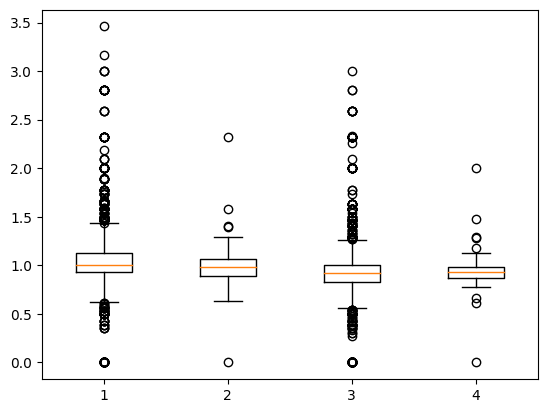

In [100]:
import numpy as np

data = []
names = []

for name, group in pos_table.groupby([labels.lang, labels.mother]):
    data.append((np.log(group.VERB) / np.log(group.NOUN) ).dropna())
    names.append(name)

fig, ax = plt.subplots()
ax.boxplot(data)
plt.show()

In [95]:
data

[speech_id
 1       0.333333
 2       0.500000
 3       0.750000
 4       0.307692
 5       0.666667
           ...   
 4410         inf
 4411    1.000000
 4412    0.000000
 4413    0.500000
 4414    1.000000
 Length: 2149, dtype: float64,
 speech_id
 23      0.250000
 25      1.000000
 129     0.500000
 131     0.604167
 161     0.500000
 483     0.666667
 485     0.666667
 487     0.727273
 505     0.714286
 507     0.277778
 561     0.600000
 564     0.666667
 582     0.857143
 604     0.333333
 658     0.785714
 696     0.555556
 946     0.642857
 948     0.404762
 950     0.470588
 1102    0.000000
 1106    0.250000
 1169    0.333333
 1324    0.555556
 1373    0.666667
 1387    0.888889
 1455    0.666667
 1456    0.750000
 1458    0.400000
 3490    0.617647
 3496    0.434783
 3508    0.617021
 3584    0.459459
 3641    0.647059
 3696    0.000000
 4078    0.187500
 4094    0.548387
 4144    0.631579
 4176    0.296296
 4218    0.666667
 4251    1.250000
 4269    0.565217
 4282    0.

In [98]:
 group.NOUN

speech_id
1536      8
1538     77
1540     30
1549     52
1571     46
1732      6
1737     19
1895     14
1995      6
2050     32
2072     10
2090      2
2305     75
2476    103
2511     32
2723      1
2785     19
2803     17
2871     32
2922     37
2977     19
3067     55
3104     89
3134     59
3166      2
3167     46
3215     42
3234     47
3284     46
3285      8
3286     10
4628      6
4630      6
4670      7
4673      5
4679     54
Name: NOUN, dtype: int64

In [106]:
token_table.loc[token_table.mother==True].value_counts('spkr')

spkr
Thetis                                                789
Venus                                                 764
Hecuba                                                731
Aphrodite                                             528
Jocasta                                               407
Venus-huntress                                        365
Cornelia Metella                                      359
Iris-Nyx                                              346
Eurydice (Opheltes' mother)                           323
Anticlea                                              293
Dione                                                 246
Ceres                                                 229
Maria                                                 217
Alcimede                                              211
Penelope                                              198
Deidamia                                              176
Chariclo                                              172
Ismenis  